In [67]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import f1_score
from dataclasses import dataclass, field
import data_providing as dp
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras import applications
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from tensorflow.keras import preprocessing

import warnings
warnings.filterwarnings('ignore')

In [27]:
# Download data and get a path to where it's downloaded
PATH_DATA = dp.fetch_product_classification_data()
PATH_TRAIN = os.path.join(PATH_DATA, 'train')
PATH_TEST = os.path.join(PATH_DATA, 'test')

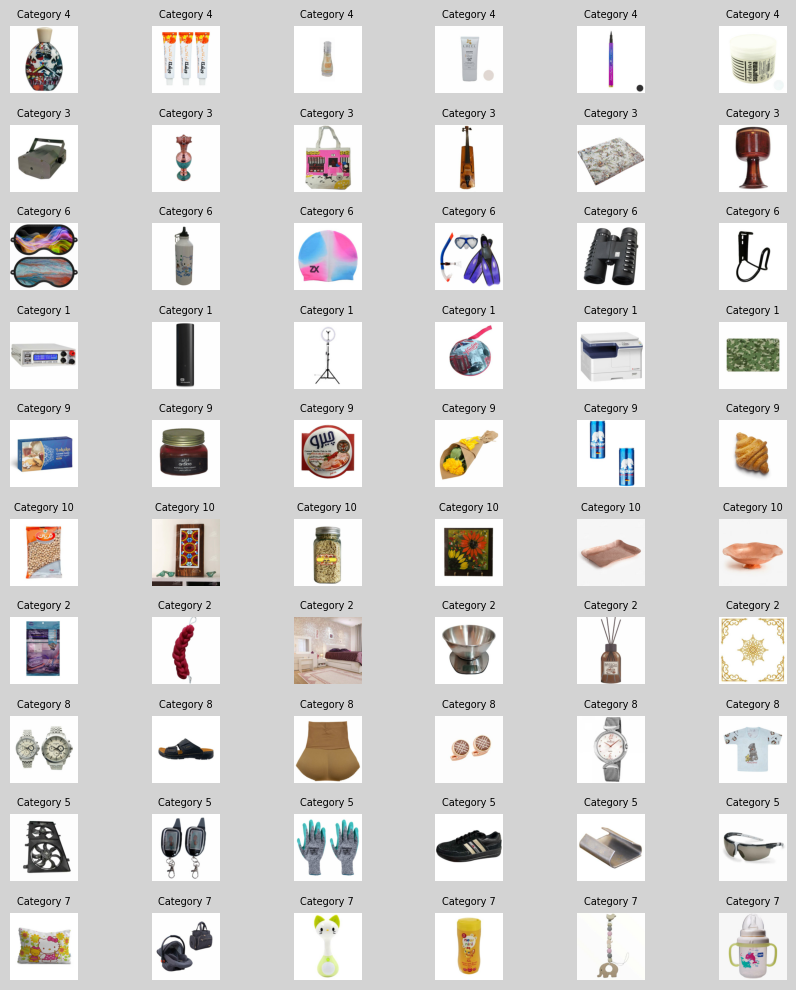

In [28]:
# Let's show some samples from dataset
SEED_VALUE = 42
ns = 6 # number of samples for each class
nc = 10 # number of classes
fig, axes = plt.subplots(nc, ns, figsize=(ns * 1.5, nc))
np.random.seed(SEED_VALUE)

for i, dir in enumerate(os.listdir(PATH_TRAIN)):
  path_dir = os.path.join(PATH_TRAIN, dir)
  file_names = os.listdir(os.path.join(PATH_TRAIN, dir))
  file_names_selected = np.random.choice(file_names, ns, replace=False)
  for j, _ in enumerate(file_names_selected):
    name_file = file_names_selected[j]
    path_file = os.path.join(path_dir, name_file)
    image_file = tf.io.read_file(path_file)
    image = tf.image.decode_image(image_file, channels=3)
    axes[i, j].imshow(image / 255)
    axes[i, j].axis('off')
    title = axes[i, j].set_title(f'Category {dir}')
    title.set_fontsize(7)

fig.set_facecolor('lightgray')
plt.tight_layout()
plt.show()

In [29]:
# Config Templates

@dataclass
class DatasetConfig:
  # Configurable
  validation_split: float = 0.2
  data_generator: dict = field(default_factory=dict)

  # Fixed configs
  IMG_HEIGHT: int = 456
  IMG_HEIGHT: int = 456
  CHANNELS: int = 3
  NUM_CLASSES: int = 10
  PATH_TRAIN: str = PATH_TRAIN
  PATH_TEST: str = PATH_TEST

@dataclass
class TrainingConfig:
  base_model: dict = field(default_factory=dict)
  batch_size: int = 16
  epochs1: int = 10
  epochs2: int = 10
  layers_finetune_rate: float = 0.2
  freeze_then_finetune: bool = False
  optimizer1: dict = field(default_factory=dict)
  optimizer2: dict = field(default_factory=dict)
  custom_layers: dict = field(default_factory=dict)

In [30]:
# Some configs for base models

BASE_MODEL_CANDIDATES = {
    'InceptionV3': {
      'model': applications.InceptionV3,
      'preprocessing_function': applications.inception_v3.preprocess_input,
      'weights': 'imagenet',
      'input_shape': (299, 299, 3),
    },
    'Xception': {
      'model': applications.Xception,
      'preprocessing_function': applications.xception.preprocess_input,
      'weights': 'imagenet',
      'input_shape': (299, 299, 3),
    },
    'Resnet152V2': {
      'model': applications.ResNet152V2,
      'preprocessing_function': applications.resnet_v2.preprocess_input,
      'weights': 'imagenet',
      'input_shape': (224, 224, 3),
    },
    'InceptionResNetV2': {
      'model': applications.InceptionResNetV2,
      'preprocessing_function': applications.inception_resnet_v2.preprocess_input,
      'weights': 'imagenet',
      'input_shape': (299, 299, 3),
    },
    'NASNetLarge': {
      'model': applications.NASNetLarge,
      'preprocessing_function': applications.nasnet.preprocess_input,
      'weights': 'imagenet',
      'input_shape': (331, 331, 3),
    },
    'EfficientNetB5': {
      'model': applications.EfficientNetB5,
      'preprocessing_function': applications.efficientnet.preprocess_input,
      'weights': 'imagenet',
      'input_shape': (456, 456, 3),
    },
    'EfficientNetV2M': {
      'model': applications.EfficientNetV2M,
      'preprocessing_function': applications.efficientnet.preprocess_input,
      'weights': 'imagenet',
      'input_shape': (260, 260, 3),
    },
    'EfficientNetV2L': {
      'model': applications.EfficientNetV2L,
      'preprocessing_function': applications.efficientnet.preprocess_input,
      'weights': 'imagenet',
      'input_shape': (300, 300, 3),
    },
    'EfficientNetV2L456': {
      'model': applications.EfficientNetV2L,
      'preprocessing_function': applications.efficientnet.preprocess_input,
      'weights': 'imagenet',
      'input_shape': (456, 456, 3),
    },
    'ConvNeXtLarge': {
      'model': applications.ConvNeXtLarge,
      'preprocessing_function': applications.resnet_v2.preprocess_input,
      'weights': 'imagenet',
      'input_shape': (299, 299, 3),
    },
  }

In [31]:
# Some configs for custom layers

CUSTOM_LAYERS_CONFIGS = {
    'default': {
        'layers_units': [1024],
        'dropout_rate': 0.2,
        'l2_rate': 0.02,
        'activation': 'relu',
        'kernel_initializer': 'random_normal',
    },
}

In [32]:
# Some candidates for optimizers

OPTIMIZERS = {
    'adam': optimizers.Adam,
    'rmsprop': optimizers.RMSprop,
    'sgd': optimizers.SGD,
    'adamax': optimizers.Adamax,
    'nadam': optimizers.Nadam,
}

OPTIMIZERS_CONFIGS = {
    'default': {
        'name': 'adam',
        'config': {
            'learning_rate': 0.0001,
        },
    },
    'rmsprop': {
        'name': 'rmsprop',
        'config': {
           'learning_rate': 0.0001,
        },
    },
}

In [33]:
# Some configs for image generators

DATA_GENERATOR_CONFIGS = {
    'default': {
        'rotation_range': 30,
        'width_shift_range': 0.3,
        'height_shift_range': 0.3,
        'shear_range': 0.3,
        'zoom_range': 0.3,
        'horizontal_flip': True,
        'vertical_flip': True,
        'fill_mode': 'nearest',
    },
}

In [34]:

def prepare_data(train_config, dataset_config):

    """
    Prepare data for training and validation

    Args:
        train_config: train configuration, type: TrainingConfig
        dataset_config: dataset configuration, type: DatasetConfig

    Returns:
        train_generator: a generator for training data,
            type: tf.keras.preprocessing.image.DirectoryIterator

        validation_generator: a generator for validation data,
            type: tf.keras.preprocessing.image.DirectoryIterator
    """

    datagen = preprocessing.image.ImageDataGenerator(
        preprocessing_function=train_config.base_model['preprocessing_function'],
        validation_split=dataset_config.validation_split,
        **dataset_config.data_generator,
    )

    # train data generators
    train_generator = datagen.flow_from_directory(
        dataset_config.PATH_TRAIN,
        target_size=train_config.base_model['input_shape'][:2],
        batch_size=train_config.batch_size,
        class_mode='categorical',
        subset='training',
        seed=SEED_VALUE,
    )

    # validation data generators
    valid_generator = datagen.flow_from_directory(
        dataset_config.PATH_TRAIN,
        target_size=train_config.base_model['input_shape'][:2],
        batch_size=train_config.batch_size,
        class_mode='categorical',
        subset='validation',
        seed=SEED_VALUE,
    )

    return train_generator, valid_generator

In [35]:
def try_model(train_config, dataset_config):

    # Get data generators
    train_generator, valid_generator = prepare_data(train_config, dataset_config)

    # Set input shape
    input_shape = train_config.base_model['input_shape']

    base_model = train_config.base_model['model'](
        weights=train_config.base_model['weights'],
        include_top=False,
        input_shape=input_shape,
    )

    # Specify the number of layers to fine tune at the end of the convolutional base
    num_layers_fine_tune = int(train_config.layers_finetune_rate * len(base_model.layers))
    num_layers_base_model = len(base_model.layers)

    if train_config.freeze_then_finetune:
         # freeze all layers
        ff = num_layers_base_model
    else:
        # freeze the first layers
        ff = num_layers_base_model - num_layers_fine_tune

    for model_layer in base_model.layers[:ff]:
        model_layer.trainable = False

    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)

    # Add dense layers
    for layer_units in train_config.custom_layers['layers_units']:
        x = layers.Dense(
            layer_units,
            kernel_regularizer=regularizers.L2(train_config.custom_layers['l2_rate']),
            activation=train_config.custom_layers['activation'],
            kernel_initializer=train_config.custom_layers['kernel_initializer'])(x)
        x = layers.Dropout(train_config.custom_layers['dropout_rate'])(x)

    # Add output layer
    predctions = layers.Dense(
        dataset_config.NUM_CLASSES,
        kernel_initializer=train_config.custom_layers['kernel_initializer'],
        activation='softmax')(x)

    # This is the model we will train
    model = models.Model(inputs=base_model.input, outputs=predctions)

    # print(model.summary())

    # Compile the model
    model.compile(
        optimizer=OPTIMIZERS[train_config.optimizer1['name']](
            **train_config.optimizer1['config']),
        loss='categorical_crossentropy', metrics=['accuracy'],
    )

    # Add an early stopping callback
    early_stopping1 = callbacks.EarlyStopping(
        monitor='val_loss', patience=5, restore_best_weights=True)

    # Create a ModelCheckpoint callback to save the weights during training
    checkpoint1 = callbacks.ModelCheckpoint(
        'model_weights1.h5', monitor='val_loss', save_best_only=True, mode='min')

    # Train the model
    history = model.fit(
        train_generator,
        validation_data=valid_generator,
        epochs=train_config.epochs1,
        steps_per_epoch = train_generator.samples // train_generator.batch_size,
        callbacks=[early_stopping1, checkpoint1],
    )

    # Fine tune after unfreezing some layers if freeze_then_finetune is True
    if train_config.freeze_then_finetune:
        print('-------Finetuning started-------')
        ff = num_layers_base_model - num_layers_fine_tune
        for model_layer in model.layers[ff:]:
            model_layer.trainable = True

        # Recompile
        model.compile(
            optimizer=OPTIMIZERS[train_config.optimizer2['name']](
                **train_config.optimizer2['config']),
            loss='categorical_crossentropy', metrics=['accuracy']),

        # Add an early stopping callback
        early_stopping2 = callbacks.EarlyStopping(
            monitor='val_loss', patience=5, restore_best_weights=True)

        # Create a ModelCheckpoint callback to save the weights during training
        checkpoint2 = callbacks.ModelCheckpoint(
            'model_weights2.h5', monitor='val_loss', save_best_only=True, mode='min')
        
        # Fit again
        history = model.fit(
            train_generator,
            validation_data=valid_generator,
            epochs=train_config.epochs2,
            steps_per_epoch = train_generator.samples // train_generator.batch_size,
            callbacks=[early_stopping2, checkpoint2],
        )

    return model, history, train_generator, valid_generator

In [37]:
### Try an EfficientNet-based model  ###

# Set dataset configs
dataset_config_efficientnet = DatasetConfig(
    validation_split=0.2,
    data_generator=DATA_GENERATOR_CONFIGS['default'],
)

# Set training configs
train_config_efficientnet = TrainingConfig(
    base_model=BASE_MODEL_CANDIDATES['EfficientNetV2L456'],
    batch_size=64,
    epochs1=25,
    epochs2=None,
    layers_finetune_rate=0.2,
    freeze_then_finetune=False,
    optimizer1=OPTIMIZERS_CONFIGS['default'],
    optimizer2={},
    custom_layers=CUSTOM_LAYERS_CONFIGS['default'],
)

model, history, train, validation = try_model(
    train_config_efficientnet,
    dataset_config_efficientnet,
)


Found 7994 images belonging to 10 classes.
Found 1996 images belonging to 10 classes.
Epoch 1/25


2023-11-12 10:01:58.987929: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_4/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


124/124 [==============================] - 375s 3s/step - loss: 56.7257 - accuracy: 0.5057 - val_loss: 47.0328 - val_accuracy: 0.6232
Epoch 2/25
124/124 [==============================] - 331s 3s/step - loss: 39.6324 - accuracy: 0.6997 - val_loss: 33.1795 - val_accuracy: 0.6618
Epoch 3/25
124/124 [==============================] - 330s 3s/step - loss: 27.7461 - accuracy: 0.7826 - val_loss: 23.4121 - val_accuracy: 0.6889
Epoch 4/25
124/124 [==============================] - 332s 3s/step - loss: 19.3696 - accuracy: 0.8421 - val_loss: 16.6423 - val_accuracy: 0.6879
Epoch 5/25
124/124 [==============================] - 329s 3s/step - loss: 13.4918 - accuracy: 0.8856 - val_loss: 11.8817 - val_accuracy: 0.6929
Epoch 6/25
124/124 [==============================] - 329s 3s/step - loss: 9.3763 - accuracy: 0.9091 - val_loss: 8.5502 - val_accuracy: 0.6939
Epoch 7/25
124/124 [==============================] - 330s 3s/step - loss: 6.5035 - accuracy: 0.9304 - val_loss: 6.2760 - val_accuracy: 0.6934


In [53]:
# Final accuracy on validation data
loss_val, accuracy_val = model.evaluate_generator(validation)
print(f"Validation Loss: {loss_val:.4f}, Validation Accuracy: {accuracy_val * 100:.2f}%")

Validation Loss: 1.3196, Validation Accuracy: 71.39%


In [45]:
# Calculate micro F1 score validation data

y_true = []
y_pred = []

for i in range(len(validation)):
    batch = validation[i]
    x_batch, y_batch = batch
    
    # Convert one-hot encoded labels to integers
    y_true.extend(np.argmax(y_batch, axis=1)) 
    y_pred.extend(np.argmax(model.predict(x_batch), axis=1))

micro_f1 = f1_score(y_true, y_pred, average='micro')

print(f"Micro F1 Score (on validation): {micro_f1 * 100:.2f}%")

del y_true
del y_pred

1/1 [==============================] - 0s 92ms/step
Micro F1 Score (on validation): 71.09%


In [ ]:
# Let's predict some samples from validation dataset

samples_per_category = 3
validation.reset()

fig, axes = plt.subplots(
    len(validation.class_indices), 
    samples_per_category, 
    figsize=(15, 3 * len(validation.class_indices)))

samples_displayed = {category: 0 for category in validation.class_indices.keys()}

for i in range(len(validation)):
    
    validation_data, validation_labels = validation.next()
    predictions = model.predict(validation_data)
    class_indices = validation.class_indices
    class_labels = {v: k for k, v in class_indices.items()}

    for j in range(validation_data.shape[0]):
        img = validation_data[j]
        true_label = class_labels[np.argmax(validation_labels[j])]
        predicted_label = class_labels[np.argmax(predictions[j])]

        if samples_displayed[true_label] < samples_per_category:
            axes[class_indices[true_label], samples_displayed[true_label]].imshow(preprocessing.image.array_to_img(img))
            axes[class_indices[true_label], samples_displayed[true_label]].set_title(f'True: {true_label}\nPredicted: {predicted_label}')
            axes[class_indices[true_label], samples_displayed[true_label]].axis('off')
            samples_displayed[true_label] += 1

        if all(samples >= samples_per_category for samples in samples_displayed.values()):
            break
    else:
        continue
    break

fig.set_facecolor('lightgray')
plt.tight_layout()
plt.show()


<center>
<div style="max-width:600px">
<img src="smaples_predictions.png" >
</div>
</center>

In [57]:
### Train model again, but this time almost on the whole dataset ###

# Set validation_split too low
dataset_config_efficientnet = DatasetConfig(
    validation_split=0.02,
    data_generator=DATA_GENERATOR_CONFIGS['default'],
)

model_final, history_final, train, validation = try_model(
    train_config_efficientnet,
    dataset_config_efficientnet,
)

Found 9794 images belonging to 10 classes.
Found 196 images belonging to 10 classes.
Epoch 1/25


2023-11-12 13:28:21.697891: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_10/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


153/153 [==============================] - 410s 2s/step - loss: 54.6539 - accuracy: 0.5272 - val_loss: 43.3741 - val_accuracy: 0.6378
Epoch 2/25
153/153 [==============================] - 379s 2s/step - loss: 35.2208 - accuracy: 0.7091 - val_loss: 28.3829 - val_accuracy: 0.6122
Epoch 3/25
153/153 [==============================] - 389s 3s/step - loss: 22.7802 - accuracy: 0.7750 - val_loss: 18.5294 - val_accuracy: 0.6633
Epoch 4/25
153/153 [==============================] - 385s 3s/step - loss: 14.7413 - accuracy: 0.8394 - val_loss: 12.3507 - val_accuracy: 0.6837
Epoch 5/25
153/153 [==============================] - 384s 3s/step - loss: 9.4916 - accuracy: 0.8726 - val_loss: 8.1637 - val_accuracy: 0.7194
Epoch 6/25
153/153 [==============================] - 358s 2s/step - loss: 6.1128 - accuracy: 0.9024 - val_loss: 5.7510 - val_accuracy: 0.6837
Epoch 7/25
153/153 [==============================] - 338s 2s/step - loss: 3.9276 - accuracy: 0.9297 - val_loss: 4.0748 - val_accuracy: 0.7041
Ep

In [68]:
### Predict test dataset ###

testdatagen = preprocessing.image.ImageDataGenerator(
    preprocessing_function= train_config_efficientnet.base_model['preprocessing_function'])

test_generator = testdatagen.flow_from_directory(
    DatasetConfig.PATH_TEST,
    target_size=train_config_efficientnet.base_model['input_shape'][:2],
    batch_size=1,
    class_mode=None,
    shuffle=False,
    seed=SEED_VALUE,
)

test_generator.reset()
predicts = model_final.predict_generator(
    test_generator, 
    steps=len(test_generator), 
    verbose=1,
)

predicted_class_indices = np.argmax(predicts, axis=1)

labels = (train.class_indices)
labels = dict((v, k) for k, v in labels.items())
predictions = [labels[v] for v in predicted_class_indices]


filenames = test_generator.filenames
results = pd.DataFrame({
    "name": filenames,
    "predicted": predictions,
})
results.to_csv("q1_submission.csv", index=False)

Found 4000 images belonging to 1 classes.
4000/4000 [==============================] - 122s 30ms/step
